## Taylor Rule

In [1]:
import pandas as pd
import numpy as np

# Consumer Price Index for All Urban Consumers:
CPIAUCSL = pd.read_csv("/Users/chriskuo/My_documents_all/FraudDetection_full/Datasets/CPIAUCSL.csv")
# Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average
CPILFESL = pd.read_csv("/Users/chriskuo/My_documents_all/FraudDetection_full/Datasets/CPILFESL.csv")
# Gross Domestic Product: Implicit Price Deflator 
GDPDEF = pd.read_csv("/Users/chriskuo/My_documents_all/FraudDetection_full/Datasets/GDPDEF.csv")
# Personal Consumption Expenditures: Chain-type Price Index 
PCEPI = pd.read_csv("/Users/chriskuo/My_documents_all/FraudDetection_full/Datasets/PCEPI.csv")
# Real Gross Domestic Product
GDPC1 = pd.read_csv("/Users/chriskuo/My_documents_all/FraudDetection_full/Datasets/GDPC1.csv")
# Potential GDP
GDPPOT = pd.read_csv("/Users/chriskuo/My_documents_all/FraudDetection_full/Datasets/GDPPOT.csv")
# Federal Funds Rate
FEDFUNDS = pd.read_csv("/Users/chriskuo/My_documents_all/FraudDetection_full/Datasets/FEDFUNDS.csv")

In [2]:
CPIAUCSL[400:]

,DATE,CPIAUCSL
400,1980-05-01,81.700
401,1980-06-01,82.500
402,1980-07-01,82.600
403,1980-08-01,83.200
404,1980-09-01,83.900
...,...,...
885,2020-10-01,260.462
886,2020-11-01,260.927
887,2020-12-01,261.560
888,2021-01-01,262.231


In [3]:
# GDP indexes are quarterly. Create monthly data by forward filling
month = CPIAUCSL['DATE']
GDPDEF = pd.merge(month, GDPDEF, left_on = 'DATE', right_on = 'DATE', how='left')
GDPPOT = pd.merge(month, GDPPOT, left_on = 'DATE', right_on = 'DATE', how='left') 
GDPC1 = pd.merge(month, GDPC1, left_on = 'DATE', right_on = 'DATE', how='left')

from functools import reduce
dfs = [CPIAUCSL, CPILFESL, GDPDEF, PCEPI, GDPC1, GDPPOT,FEDFUNDS] 
data = reduce(lambda  left,right: pd.merge(left,right,on=['DATE'],how='outer'), dfs)
data = data.fillna(method='ffill') # Forward filling
data = data.dropna( how='any') # drop the NAs of old time periods
data['GDP_gap'] = 100 * (data['GDPC1'] / data['GDPPOT'] -1)
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d').dt.strftime('%Y-%m')
data.index = data['DATE']

In [4]:
data['rCPIAUCSL'] = 100 * ( data['CPIAUCSL'] / data['CPIAUCSL'].shift(12) -1 )
data['rCPILFESL'] = 100 * ( data['CPILFESL'] /  data['CPILFESL'].shift(12) -1 )
data['rGDPDEF'] = 100 * ( data['GDPDEF'] /  data['GDPDEF'].shift(12) -1 )
data['rPCEPI'] = 100 * ( data['PCEPI'] /  data['PCEPI'].shift(12) -1 )
data.head()

,DATE,CPIAUCSL,CPILFESL,GDPDEF,PCEPI,GDPC1,GDPPOT,FEDFUNDS,GDP_gap,rCPIAUCSL,rCPILFESL,rGDPDEF,rPCEPI
DATE,,,,,,,,,,,,,
1959-01,1959-01,29.01,29.9,16.347,16.074,3121.936,3120.055781,2.48,0.060262,NaN,NaN,NaN,NaN
1959-02,1959-02,29.00,29.9,16.347,16.089,3121.936,3120.055781,2.43,0.060262,NaN,NaN,NaN,NaN
1959-03,1959-03,28.97,30.0,16.347,16.100,3121.936,3120.055781,2.80,0.060262,NaN,NaN,NaN,NaN
1959-04,1959-04,28.98,30.0,16.372,16.132,3192.380,3150.376690,2.96,1.333279,NaN,NaN,NaN,NaN
1959-05,1959-05,29.04,30.1,16.372,16.140,3192.380,3150.376690,2.90,1.333279,NaN,NaN,NaN,NaN


In [5]:
# Taylor formula
def taylor(inflation, GDP_gap):
    i = inflation + 0.5 * GDP_gap + 0.5 * (inflation - 2) + 2
    return i

# The federal funds rate should be 1.2% + 0.5 * -3% + 0.5 * (1.2%–2%) + 2% = 1.3%.
taylor(1.200, -3.00)

1.2999999999999998

In [6]:
# Taylor rule formula
def taylor(inflation):
    data['ff'+inflation] = data[inflation] + 0.5 * data['GDP_gap'] + 0.5 * (data[inflation] - 2) + 2
    return data

inf_list = ['rCPIAUCSL','rCPILFESL','rGDPDEF','rPCEPI']
for inflation in  inf_list:
   taylor(inflation)

In [7]:
data[300:].columns

Index(['DATE', 'CPIAUCSL', 'CPILFESL', 'GDPDEF', 'PCEPI', 'GDPC1', 'GDPPOT',
       'FEDFUNDS', 'GDP_gap', 'rCPIAUCSL', 'rCPILFESL', 'rGDPDEF', 'rPCEPI',
       'ffrCPIAUCSL', 'ffrCPILFESL', 'ffrGDPDEF', 'ffrPCEPI'],
      dtype='object')

In [8]:
start_date = '1980-01-01'
end_date = '2020-01-01'
start_date = pd.to_datetime(start_date, format='%Y-%m-%d').strftime('%Y-%m')
data3 = data[(data.index >= start_date) 
            & (data.index <= end_date)]
data3

,DATE,CPIAUCSL,CPILFESL,GDPDEF,PCEPI,GDPC1,GDPPOT,FEDFUNDS,GDP_gap,rCPIAUCSL,rCPILFESL,rGDPDEF,rPCEPI,ffrCPIAUCSL,ffrCPILFESL,ffrGDPDEF,ffrPCEPI
DATE,,,,,,,,,,,,,,,,,
1980-01,1980-01,78.000,76.700,40.801,39.349,6837.641,6847.634303,13.82,-0.145938,13.868613,11.970803,8.872345,10.496757,21.729951,18.883235,14.235548,16.672166
1980-02,1980-02,79.000,77.500,40.801,39.776,6837.641,6847.634303,14.13,-0.145938,14.161850,11.994220,8.872345,11.099939,22.169806,18.918360,14.235548,17.576939
1980-03,1980-03,80.100,78.600,40.801,40.264,6837.641,6847.634303,17.19,-0.145938,14.592275,12.607450,8.872345,11.593359,22.815443,19.838206,14.235548,18.317070
1980-04,1980-04,80.900,79.500,41.772,40.475,6696.753,6890.338742,17.61,-2.809524,14.589235,13.086771,8.798250,11.021203,21.479091,19.225394,12.792612,16.127042
1980-05,1980-05,81.700,80.100,41.772,40.790,6696.753,6890.338742,10.98,-2.809524,14.425770,13.135593,8.798250,10.737071,21.233893,19.298628,12.792612,15.700844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09,2019-09,256.532,264.603,112.531,110.167,19141.744,18976.490000,2.04,0.870835,1.724541,2.347467,1.733054,1.385962,4.022230,4.956618,4.034998,3.514360
2019-10,2019-10,257.387,265.026,112.950,110.377,19253.959,19065.580000,1.83,0.988058,1.774621,2.330987,1.628577,1.434532,4.155961,4.990510,3.936894,3.645827
2019-11,2019-11,257.989,265.427,112.950,110.461,19253.959,19065.580000,1.55,0.988058,2.043730,2.317522,1.628577,1.439946,4.559625,4.970312,3.936894,3.653947


In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

data2 = data[['DATE','FEDFUNDS','ffrCPIAUCSL', 'ffrCPILFESL', 'ffrGDPDEF', 'ffrPCEPI']]
data2.columns = ['DATE', 'Effective Federal Funds Rate', 
                   'Predicted Federal Funds Rate: CPI All Urban Consumers',
                   'Predicted Federal Funds Rate: CPI All Urban Consumers - All Items Less Food and Energy', 
                   'Predicted Federal Funds Rate: GGP Implicit Price Deflator', 
                   'Predicted Federal Funds Rate: Personal Consumption Expenditures Price Index']
data2 = data2.dropna( how='any') # drop the NAs of old time periods

<AxesSubplot:>

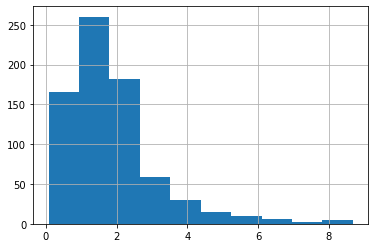

In [10]:
data2['Pred_max_min'] = data2[data2.columns[2:6]].max(axis=1) - data2[data2.columns[2:6]].min(axis=1)
data2['Pred_max_min'].hist()

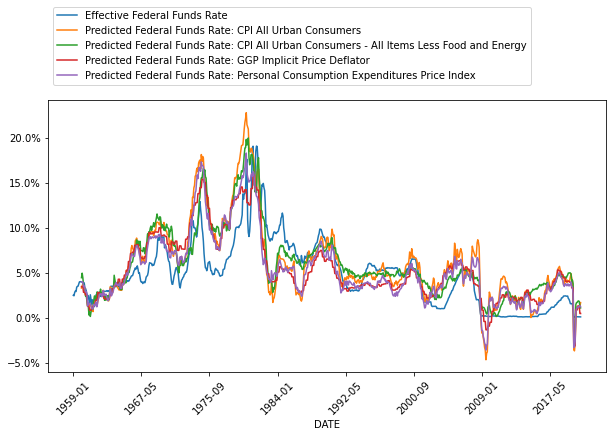

In [10]:
f = plt.figure(figsize=(10,5))
# plt.title('Title here!', color='black')
ax = data2.plot(kind='line', ax=f.gca(),  rot=45)
ax.legend(loc='center left', bbox_to_anchor=(0, 1.2))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()